# KITTI Dataset Exploration

In [1]:

basedir = 'data'

class KITTIRawData:
    
    def __init__(self, basedir, date, drive):
        self.basedir = basedir
        self.date = date
        self.drive = drive
        self.drive_path = os.path.join(basedir, date, f'{date}_drive_{drive}_sync')
        
        # Define paths
        self.velo_path = os.path.join(self.drive_path, 'velodyne_points', 'data')
        self.gray_left_path = os.path.join(self.drive_path, 'image_00', 'data')
        self.gray_right_path = os.path.join(self.drive_path, 'image_01', 'data')
        self.rgb_left_path = os.path.join(self.drive_path, 'image_02', 'data')
        self.rgb_right_path = os.path.join(self.drive_path, 'image_03', 'data')
        self.calib_path = os.path.join(basedir, date)
        
        self.timestamps = self._load_timestamps()
        
        velo_files = sorted(os.listdir(self.velo_path))
        self.frames = range(len(velo_files))
        
    def _load_timestamps(self):
        """Load timestamps from file"""
        timestamp_file = os.path.join(self.drive_path, 'velodyne_points', 'timestamps.txt')
        if os.path.exists(timestamp_file):
            with open(timestamp_file, 'r') as f:
                timestamps = [line.strip() for line in f.readlines()]
            return timestamps
        return []
    
    def load_velo(self, frame_idx):
        """Load Velodyne point cloud for a specific frame"""
        velo_file = os.path.join(self.velo_path, f'{frame_idx:010d}.bin')
        points = np.fromfile(velo_file, dtype=np.float32).reshape(-1, 4)
        return points
    
    def load_gray(self, frame_idx):
        """Load grayscale stereo pair"""
        left_file = os.path.join(self.gray_left_path, f'{frame_idx:010d}.png')
        right_file = os.path.join(self.gray_right_path, f'{frame_idx:010d}.png')
        left_img = plt.imread(left_file)
        right_img = plt.imread(right_file)
        return [left_img, right_img]
    
    def load_rgb(self, frame_idx):
        """Load RGB stereo pair"""
        left_file = os.path.join(self.rgb_left_path, f'{frame_idx:010d}.png')
        right_file = os.path.join(self.rgb_right_path, f'{frame_idx:010d}.png')
        left_img = plt.imread(left_file)
        right_img = plt.imread(right_file)
        return [left_img, right_img]
    
    @property
    def velo(self):
        """Generator for all velodyne frames"""
        for frame_idx in self.frames:
            yield self.load_velo(frame_idx)
    
    @property
    def gray(self):
        """Generator for all grayscale frames"""
        for frame_idx in self.frames:
            yield self.load_gray(frame_idx)
    
    @property
    def rgb(self):
        """Generator for all RGB frames"""
        for frame_idx in self.frames:
            yield self.load_rgb(frame_idx)

def load_dataset(date, drive, calibrated=False, frame_range=None):
    dataset = KITTIRawData(basedir, date, drive)

    np.set_printoptions(precision=4, suppress=True)
    print('\nDrive:', dataset.drive)
    print('\nFrame range:', list(dataset.frames)[:10], '...')  # Show first 10 frames

    return dataset

In [2]:
from source import parseTrackletXML as xmlParser

def load_tracklets_for_frames(n_frames, xml_path):
    """
    Loads dataset labels also referred to as tracklets, saving them individually for each frame.

    Parameters
    ----------
    n_frames    : Number of frames in the dataset.
    xml_path    : Path to the tracklets XML.

    Returns
    -------
    Tuple of dictionaries with integer keys corresponding to absolute frame numbers and arrays as values. First array
    contains coordinates of bounding box vertices for each object in the frame, and the second array contains objects
    types as strings.
    """
    tracklets = xmlParser.parseXML(xml_path)

    frame_tracklets = {}
    frame_tracklets_types = {}
    for i in range(n_frames):
        frame_tracklets[i] = []
        frame_tracklets_types[i] = []

    for i, tracklet in enumerate(tracklets):
        h, w, l = tracklet.size
        trackletBox = np.array([
            [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
            [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
            [0.0, 0.0, 0.0, 0.0, h, h, h, h]
        ])
        for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber in tracklet:
            if truncation not in (xmlParser.TRUNC_IN_IMAGE, xmlParser.TRUNC_TRUNCATED):
                continue
            yaw = rotation[2]  # other rotations are supposedly 0
            assert np.abs(rotation[:2]).sum() == 0, 'object rotations other than yaw given!'
            rotMat = np.array([
                [np.cos(yaw), -np.sin(yaw), 0.0],
                [np.sin(yaw), np.cos(yaw), 0.0],
                [0.0, 0.0, 1.0]
            ])
            cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (8, 1)).T
            frame_tracklets[absoluteFrameNumber] = frame_tracklets[absoluteFrameNumber] + [cornerPosInVelo]
            frame_tracklets_types[absoluteFrameNumber] = frame_tracklets_types[absoluteFrameNumber] + [
                tracklet.objectType]

    return (frame_tracklets, frame_tracklets_types)

Load the dataset downloaded from [KITTI website](http://www.cvlibs.net/datasets/kitti/raw_data.php). 

[2011_09_26_drive_0001 (0.4 GB)](http://kitti.is.tue.mpg.de/kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip)

* **Length**: 114 frames (00:11 minutes)
* **Image resolution**: `1392 x 512` pixels
* **Labels**: 12 Cars, 0 Vans, 0 Trucks, 0 Pedestrians, 0 Sitters, 2 Cyclists, 1 Trams, 0 Misc

In [3]:
import os
import numpy as np
date = '2011_09_26'
drive = '0048'
dataset = load_dataset(date, drive)
tracklet_rects, tracklet_types = load_tracklets_for_frames(len(list(dataset.velo)), 'data/{}/{}_drive_{}_sync/tracklet_labels.xml'.format(date, date, drive))


Drive: 0048

Frame range: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ...
Parsing tracklet file data/2011_09_26/2011_09_26_drive_0048_sync/tracklet_labels.xml
File contains 8 tracklets
Loaded 8 tracklets.


Looking at the points distributions, we could catch something meaningful if we limit **X**, **Y** and **Z** axis to some magic numbers.

Additionally we will only visualise 20% of the point cloud, as each frame contains ~120K points.

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

colors = {
    'Car': 'b',
    'Tram': 'r',
    'Cyclist': 'g',
    'Van': 'c',
    'Truck': 'm',
    'Pedestrian': 'y',
    'Sitter': 'k'
}
axes_limits = [
    [-20, 80], # X axis range
    [-20, 20], # Y axis range
    [-3, 10]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

def display_frame_statistics(dataset, tracklet_rects, tracklet_types, frame, points=0.2):
    """
    Displays statistics for a single frame. Draws camera data, 3D plot of the lidar point cloud data and point cloud
    projections to various planes.
    
    Parameters
    ----------
    dataset         : `raw` dataset.
    tracklet_rects  : Dictionary with tracklet bounding boxes coordinates.
    tracklet_types  : Dictionary with tracklet types.
    frame           : Absolute number of the frame.
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.
    """
    dataset_gray = list(dataset.gray)
    dataset_rgb = list(dataset.rgb)
    dataset_velo = list(dataset.velo)
    
    print('Frame timestamp: ' + str(dataset.timestamps[frame]))
    # Draw camera data
    f, ax = plt.subplots(2, 2, figsize=(15, 5))
    ax[0, 0].imshow(dataset_gray[frame][0], cmap='gray')
    ax[0, 0].set_title('Left Gray Image (cam0)')
    ax[0, 1].imshow(dataset_gray[frame][1], cmap='gray')
    ax[0, 1].set_title('Right Gray Image (cam1)')
    ax[1, 0].imshow(dataset_rgb[frame][0])
    ax[1, 0].set_title('Left RGB Image (cam2)')
    ax[1, 1].imshow(dataset_rgb[frame][1])
    ax[1, 1].set_title('Right RGB Image (cam3)')
    plt.show()

    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, dataset_velo[frame].shape[0], points_step)
    velo_frame = dataset_velo[frame][velo_range, :]      
    def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        ax.scatter(*np.transpose(velo_frame[:, axes]), s=point_size, c=velo_frame[:, 3], cmap='gray')
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
            
        for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
            draw_box(ax, t_rects, axes=axes, color=colors[t_type])
            
    # Draw point cloud data as 3D plot
    f2 = plt.figure(figsize=(15, 8))
    ax2 = f2.add_subplot(111, projection='3d')                    
    draw_point_cloud(ax2, 'Velodyne scan', xlim3d=(-10,30))
    plt.show()
    
    # Draw point cloud data as plane projections
    f, ax3 = plt.subplots(3, 1, figsize=(15, 25))
    draw_point_cloud(
        ax3[0], 
        'Velodyne scan, XZ projection (Y = 0), the car is moving in direction left to right', 
        axes=[0, 2] # X and Z axes
    )
    draw_point_cloud(
        ax3[1], 
        'Velodyne scan, XY projection (Z = 0), the car is moving in direction left to right', 
        axes=[0, 1] # X and Y axes
    )
    draw_point_cloud(
        ax3[2], 
        'Velodyne scan, YZ projection (X = 0), the car is moving towards the graph plane', 
        axes=[1, 2] # Y and Z axes
    )
    plt.show()

Frame timestamp: 2011-09-26 14:14:11.935383231


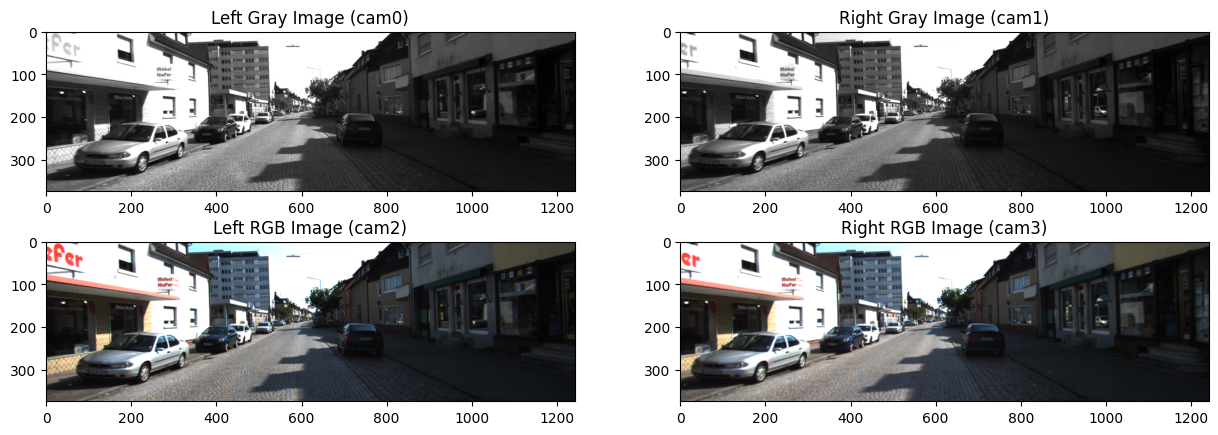

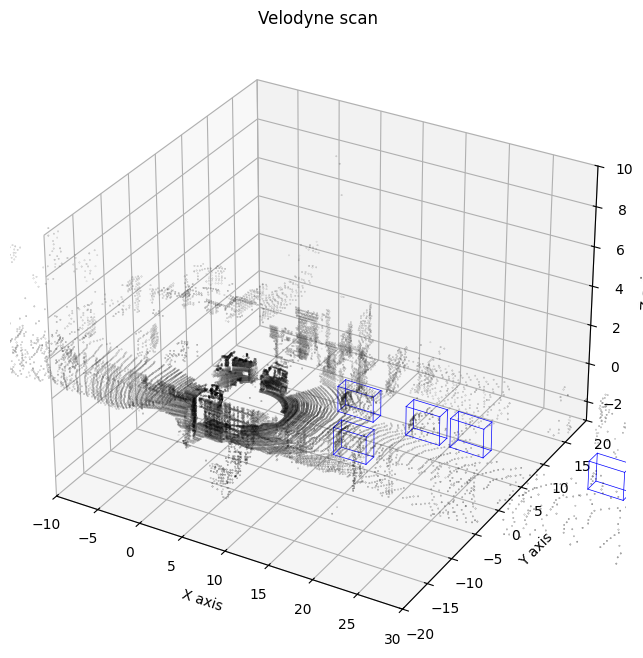

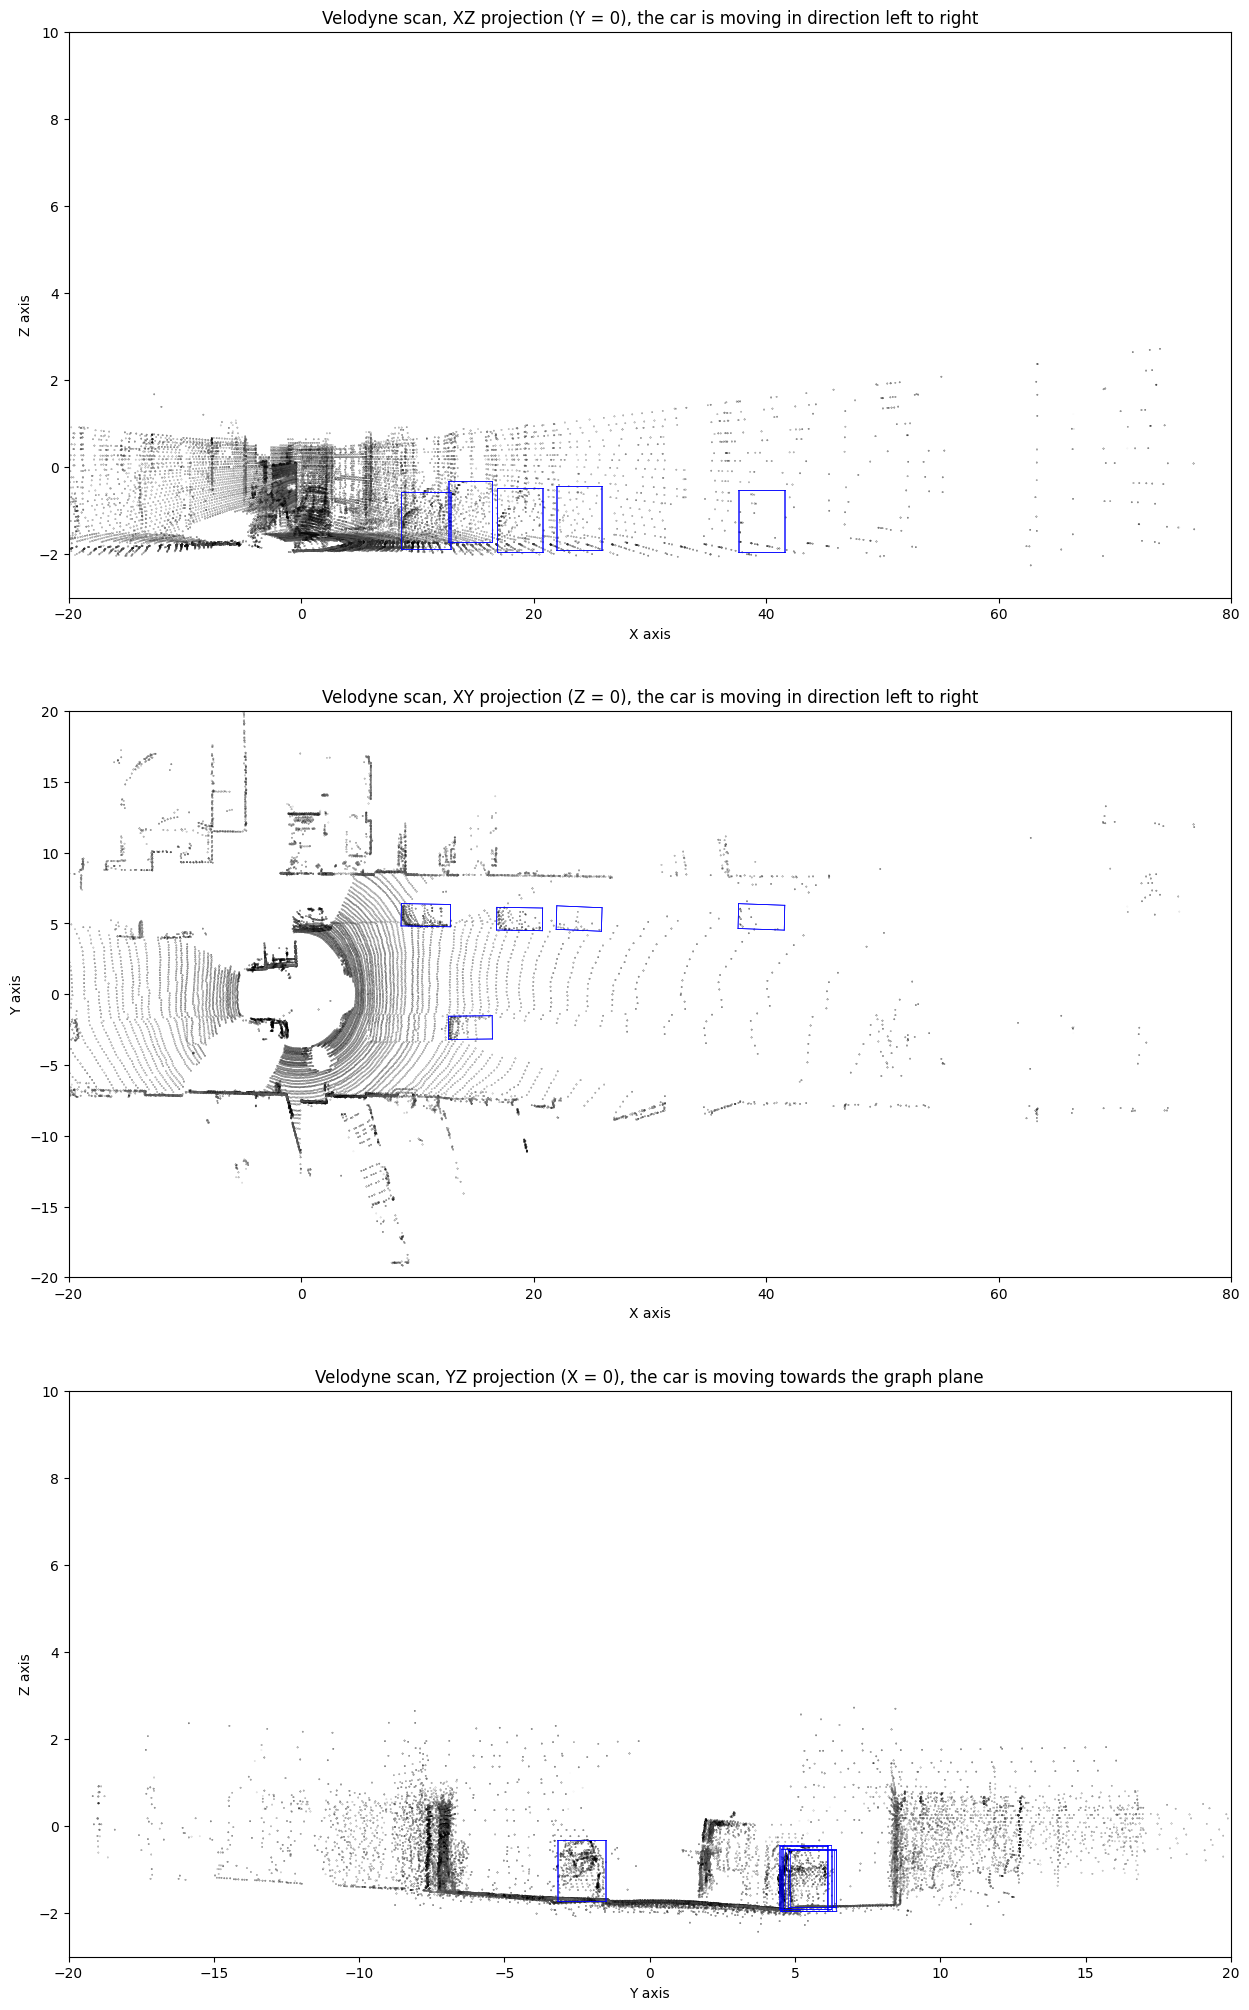

In [5]:
frame = 10

display_frame_statistics(dataset, tracklet_rects, tracklet_types, frame)

## Interactive Frame Explorer

Use the slider below to interactively explore different frames in the dataset with 3D lidar visualization and bounding boxes.

In [6]:
from ipywidgets import interact, IntSlider, FloatSlider, Checkbox, VBox, HBox, Label
import ipywidgets as widgets

def interactive_frame_explorer(frame, points=0.2, show_cameras=True, show_3d=True, show_projections=True, 
                                xlim_min=-10, xlim_max=30, azimuth=-60, elevation=30):
    """
    Interactive visualization of a single frame with adjustable parameters.
    
    Parameters
    ----------
    frame           : Frame number to display
    points          : Fraction of lidar points to use (0.1 to 1.0)
    show_cameras    : Whether to show camera images
    show_3d         : Whether to show 3D point cloud
    show_projections: Whether to show 2D projections
    xlim_min        : Minimum X-axis limit for 3D view
    xlim_max        : Maximum X-axis limit for 3D view
    azimuth         : Azimuth angle for 3D view
    elevation       : Elevation angle for 3D view
    """
    dataset_gray = list(dataset.gray)
    dataset_rgb = list(dataset.rgb)
    dataset_velo = list(dataset.velo)
    
    print(f'Frame: {frame}/{len(dataset_velo)-1}')
    print('Frame timestamp: ' + str(dataset.timestamps[frame]))
    print(f'Objects in frame: {len(tracklet_types[frame])}')
    if len(tracklet_types[frame]) > 0:
        print('Object types:', ', '.join(tracklet_types[frame]))
    
    # Draw camera data
    if show_cameras:
        f, ax = plt.subplots(2, 2, figsize=(15, 5))
        ax[0, 0].imshow(dataset_gray[frame][0], cmap='gray')
        ax[0, 0].set_title('Left Gray Image (cam0)')
        ax[0, 0].axis('off')
        ax[0, 1].imshow(dataset_gray[frame][1], cmap='gray')
        ax[0, 1].set_title('Right Gray Image (cam1)')
        ax[0, 1].axis('off')
        ax[1, 0].imshow(dataset_rgb[frame][0])
        ax[1, 0].set_title('Left RGB Image (cam2)')
        ax[1, 0].axis('off')
        ax[1, 1].imshow(dataset_rgb[frame][1])
        ax[1, 1].set_title('Right RGB Image (cam3)')
        ax[1, 1].axis('off')
        plt.tight_layout()
        plt.show()

    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, dataset_velo[frame].shape[0], points_step)
    velo_frame = dataset_velo[frame][velo_range, :]
    
    # Draw 3D point cloud
    if show_3d:
        f2 = plt.figure(figsize=(15, 8))
        ax2 = f2.add_subplot(111, projection='3d')
        ax2.scatter(*np.transpose(velo_frame[:, [0, 1, 2]]), s=point_size, c=velo_frame[:, 3], cmap='gray')
        ax2.set_title('Velodyne 3D Point Cloud with Bounding Boxes')
        ax2.set_xlabel('X axis (forward)')
        ax2.set_ylabel('Y axis (left)')
        ax2.set_zlabel('Z axis (up)')
        ax2.set_xlim3d(xlim_min, xlim_max)
        ax2.set_ylim3d(*axes_limits[1])
        ax2.set_zlim3d(*axes_limits[2])
        ax2.view_init(elev=elevation, azim=azimuth)
        
        # Draw bounding boxes
        for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
            draw_box(ax2, t_rects, axes=[0, 1, 2], color=colors[t_type])
        
        plt.show()
    
    # Draw 2D projections
    if show_projections:
        f, ax3 = plt.subplots(3, 1, figsize=(15, 20))
        
        # XZ projection
        ax3[0].scatter(*np.transpose(velo_frame[:, [0, 2]]), s=point_size, c=velo_frame[:, 3], cmap='gray')
        ax3[0].set_title('XZ projection (top view) - car moving left to right')
        ax3[0].set_xlabel('X axis (forward)')
        ax3[0].set_ylabel('Z axis (up)')
        ax3[0].set_xlim(*axes_limits[0])
        ax3[0].set_ylim(*axes_limits[2])
        for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
            draw_box(ax3[0], t_rects, axes=[0, 2], color=colors[t_type])
        
        # XY projection
        ax3[1].scatter(*np.transpose(velo_frame[:, [0, 1]]), s=point_size, c=velo_frame[:, 3], cmap='gray')
        ax3[1].set_title('XY projection (bird\'s eye view) - car moving left to right')
        ax3[1].set_xlabel('X axis (forward)')
        ax3[1].set_ylabel('Y axis (left)')
        ax3[1].set_xlim(*axes_limits[0])
        ax3[1].set_ylim(*axes_limits[1])
        for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
            draw_box(ax3[1], t_rects, axes=[0, 1], color=colors[t_type])
        
        # YZ projection
        ax3[2].scatter(*np.transpose(velo_frame[:, [1, 2]]), s=point_size, c=velo_frame[:, 3], cmap='gray')
        ax3[2].set_title('YZ projection (side view) - car moving towards viewer')
        ax3[2].set_xlabel('Y axis (left)')
        ax3[2].set_ylabel('Z axis (up)')
        ax3[2].set_xlim(*axes_limits[1])
        ax3[2].set_ylim(*axes_limits[2])
        for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
            draw_box(ax3[2], t_rects, axes=[1, 2], color=colors[t_type])
        
        plt.tight_layout()
        plt.show()

# Create interactive controls
n_frames = len(list(dataset.velo))

interact(interactive_frame_explorer,
         frame=IntSlider(min=0, max=n_frames-1, step=1, value=10, description='Frame:'),
         points=FloatSlider(min=0.05, max=1.0, step=0.05, value=0.2, description='Point Density:'),
         show_cameras=Checkbox(value=True, description='Show Cameras'),
         show_3d=Checkbox(value=True, description='Show 3D View'),
         show_projections=Checkbox(value=True, description='Show Projections'),
         xlim_min=IntSlider(min=-30, max=0, step=5, value=-10, description='X Min:'),
         xlim_max=IntSlider(min=10, max=100, step=5, value=30, description='X Max:'),
         azimuth=IntSlider(min=-180, max=180, step=10, value=-60, description='Azimuth:'),
         elevation=IntSlider(min=-90, max=90, step=10, value=30, description='Elevation:')
);

interactive(children=(IntSlider(value=10, description='Frame:', max=21), FloatSlider(value=0.2, description='P…

## Quick Frame Browser

A simpler interface to quickly browse through frames with just the 3D visualization.

## Interactive 3D Point Cloud Explorer (Plotly)

This creates a fully interactive 3D visualization where you can:
- **Rotate**: Click and drag to rotate the view
- **Zoom**: Scroll to zoom in/out
- **Pan**: Right-click and drag to pan
- **Inspect**: Hover over points and bounding boxes to see details

In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

plotly_colors = {
    'Car': 'blue',
    'Tram': 'red',
    'Cyclist': 'green',
    'Van': 'cyan',
    'Truck': 'magenta',
    'Pedestrian': 'yellow',
    'Sitter': 'black'
}

def create_interactive_3d_frame(frame, points=0.15, x_range=[-20, 60], y_range=[-20, 20], z_range=[-3, 10]):
    """
    Creates an interactive 3D visualization using Plotly.
    
    Parameters
    ----------
    frame   : Frame number to display
    points  : Fraction of lidar points to use (lower for better performance)
    x_range : X-axis range [min, max] in meters
    y_range : Y-axis range [min, max] in meters
    z_range : Z-axis range [min, max] in meters
    """
    dataset_velo = list(dataset.velo)
    
    # Sample the point cloud
    points_step = int(1. / points)
    velo_range = range(0, dataset_velo[frame].shape[0], points_step)
    velo_frame = dataset_velo[frame][velo_range, :]
    
    # Create figure
    fig = go.Figure()
    
    # Add point cloud
    fig.add_trace(go.Scatter3d(
        x=velo_frame[:, 0],
        y=velo_frame[:, 1],
        z=velo_frame[:, 2],
        mode='markers',
        marker=dict(
            size=1,
            color=velo_frame[:, 3],  # Color by intensity
            colorscale='Greys',
            opacity=0.6,
            colorbar=dict(title="Intensity")
        ),
        name='Point Cloud',
        hovertemplate='X: %{x:.2f}m<br>Y: %{y:.2f}m<br>Z: %{z:.2f}m<extra></extra>'
    ))
    
    for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
        # Get the 8 corners of the bounding box
        vertices = t_rects
        color = plotly_colors[t_type]
        
        edges = [
            [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom face
            [4, 5], [5, 6], [6, 7], [7, 4],  # Top face
            [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical edges
        ]
        
        for edge in edges:
            fig.add_trace(go.Scatter3d(
                x=[vertices[0, edge[0]], vertices[0, edge[1]]],
                y=[vertices[1, edge[0]], vertices[1, edge[1]]],
                z=[vertices[2, edge[0]], vertices[2, edge[1]]],
                mode='lines',
                line=dict(color=color, width=4),
                showlegend=False,
                hovertemplate=f'{t_type}<extra></extra>'
            ))
        
        center = np.mean(vertices, axis=1)
        fig.add_trace(go.Scatter3d(
            x=[center[0]],
            y=[center[1]],
            z=[center[2]],
            mode='text',
            text=[t_type],
            textfont=dict(size=12, color=color),
            showlegend=False,
            hovertemplate=f'{t_type}<extra></extra>'
        ))
    
    in_view = np.sum(
        (velo_frame[:, 0] >= x_range[0]) & (velo_frame[:, 0] <= x_range[1]) &
        (velo_frame[:, 1] >= y_range[0]) & (velo_frame[:, 1] <= y_range[1]) &
        (velo_frame[:, 2] >= z_range[0]) & (velo_frame[:, 2] <= z_range[1])
    )
    
    fig.update_layout(
        title=f'Frame {frame} - Interactive 3D Point Cloud (Objects: {len(tracklet_types[frame])}, Points in view: {in_view:,})',
        scene=dict(
            xaxis=dict(title='X (forward) [m]', range=x_range),
            yaxis=dict(title='Y (left) [m]', range=y_range),
            zaxis=dict(title='Z (up) [m]', range=z_range),
            aspectmode='manual',
            aspectratio=dict(x=2, y=1, z=0.3),
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.2)
            )
        ),
        width=1200,
        height=800,
        hovermode='closest'
    )
    
    return fig

def show_interactive_frame(frame, x_min=-20, x_max=60, y_min=-20, y_max=20, z_min=-3, z_max=10, point_density=0.15):
    """Display interactive 3D visualization for selected frame with adjustable zoom."""
    print(f'Frame: {frame}')
    print(f'Timestamp: {dataset.timestamps[frame]}')
    print(f'View range: X=[{x_min}, {x_max}], Y=[{y_min}, {y_max}], Z=[{z_min}, {z_max}]')
    if len(tracklet_types[frame]) > 0:
        print(f'Detected objects: {", ".join(tracklet_types[frame])}')
    else:
        print('No objects detected in this frame')
    print('\n💡 Tip: Click and drag to rotate, scroll to zoom, right-click to pan')
    print('   Use the sliders to adjust the visible range!')
    
    fig = create_interactive_3d_frame(frame, points=point_density, 
                                     x_range=[x_min, x_max], 
                                     y_range=[y_min, y_max], 
                                     z_range=[z_min, z_max])
    fig.show()

interact(show_interactive_frame,
         frame=IntSlider(min=0, max=n_frames-1, step=1, value=10, 
                        description='Frame:', continuous_update=False),
         x_min=IntSlider(min=-50, max=0, step=5, value=-20, 
                        description='X Min:', continuous_update=False),
         x_max=IntSlider(min=10, max=150, step=10, value=60, 
                        description='X Max:', continuous_update=False),
         y_min=IntSlider(min=-40, max=0, step=5, value=-20, 
                        description='Y Min:', continuous_update=False),
         y_max=IntSlider(min=5, max=40, step=5, value=20, 
                        description='Y Max:', continuous_update=False),
         z_min=IntSlider(min=-10, max=0, step=1, value=-3, 
                        description='Z Min:', continuous_update=False),
         z_max=IntSlider(min=2, max=20, step=2, value=10, 
                        description='Z Max:', continuous_update=False),
         point_density=FloatSlider(min=0.05, max=0.5, step=0.05, value=0.15, 
                                   description='Point Density:', continuous_update=False)
);

interactive(children=(IntSlider(value=10, continuous_update=False, description='Frame:', max=21), IntSlider(va…

## Advanced Interactive Explorer

Full-featured interactive 3D viewer with customizable point density and object filtering.

In [8]:
def advanced_interactive_explorer(frame, point_density=0.15, show_cars=True, show_cyclists=True, 
                                 show_trams=True, show_grid=True, color_by='intensity'):
    """
    Advanced interactive 3D visualization with filtering options.
    
    Parameters
    ----------
    frame         : Frame number to display
    point_density : Fraction of points to display (0.05-0.5)
    show_cars     : Show car bounding boxes
    show_cyclists : Show cyclist bounding boxes
    show_trams    : Show tram bounding boxes
    show_grid     : Show grid lines
    color_by      : Color points by 'intensity' or 'height'
    """
    dataset_velo = list(dataset.velo)
    
    # Sample the point cloud
    points_step = int(1. / point_density)
    velo_range = range(0, dataset_velo[frame].shape[0], points_step)
    velo_frame = dataset_velo[frame][velo_range, :]
    
    # Create figure
    fig = go.Figure()
    
    # Determine color scheme
    if color_by == 'intensity':
        point_colors = velo_frame[:, 3]
        colorscale = 'Greys'
        colorbar_title = 'Intensity'
    else:  # height
        point_colors = velo_frame[:, 2]
        colorscale = 'Viridis'
        colorbar_title = 'Height (Z)'
    
    # Add point cloud
    fig.add_trace(go.Scatter3d(
        x=velo_frame[:, 0],
        y=velo_frame[:, 1],
        z=velo_frame[:, 2],
        mode='markers',
        marker=dict(
            size=1.5,
            color=point_colors,
            colorscale=colorscale,
            opacity=0.7,
            colorbar=dict(title=colorbar_title, x=1.1)
        ),
        name='Point Cloud',
        hovertemplate='X: %{x:.2f}m<br>Y: %{y:.2f}m<br>Z: %{z:.2f}m<extra></extra>'
    ))
    
    # Filter and add bounding boxes based on user selection
    object_filter = {
        'Car': show_cars,
        'Cyclist': show_cyclists,
        'Tram': show_trams,
        'Van': True,
        'Truck': True,
        'Pedestrian': True,
        'Sitter': True
    }
    
    objects_shown = []
    for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
        if not object_filter.get(t_type, True):
            continue
            
        objects_shown.append(t_type)
        vertices = t_rects
        color = plotly_colors[t_type]
        
        # Define the 12 edges of the bounding box
        edges = [
            [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom face
            [4, 5], [5, 6], [6, 7], [7, 4],  # Top face
            [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical edges
        ]
        
        # Draw each edge with thicker lines
        for edge in edges:
            fig.add_trace(go.Scatter3d(
                x=[vertices[0, edge[0]], vertices[0, edge[1]]],
                y=[vertices[1, edge[0]], vertices[1, edge[1]]],
                z=[vertices[2, edge[0]], vertices[2, edge[1]]],
                mode='lines',
                line=dict(color=color, width=6),
                showlegend=False,
                hovertemplate=f'<b>{t_type}</b><br>Click and drag to rotate<extra></extra>'
            ))
        
        # Add label
        center = np.mean(vertices, axis=1)
        fig.add_trace(go.Scatter3d(
            x=[center[0]],
            y=[center[1]],
            z=[center[2]],
            mode='text',
            text=[t_type],
            textfont=dict(size=14, color=color, family='Arial Black'),
            showlegend=False,
            hovertemplate=f'<b>{t_type}</b><extra></extra>'
        ))
    
    # Update layout with enhanced settings
    fig.update_layout(
        title=dict(
            text=f'Frame {frame}/{n_frames-1} - Interactive 3D Point Cloud<br><sub>Objects: {len(objects_shown)} ({", ".join(set(objects_shown)) if objects_shown else "None"})</sub>',
            x=0.5,
            xanchor='center'
        ),
        scene=dict(
            xaxis=dict(
                title='X axis (forward) [m]', 
                range=[-10, 40],
                showgrid=show_grid,
                gridwidth=1,
                gridcolor='lightgray'
            ),
            yaxis=dict(
                title='Y axis (left) [m]', 
                range=axes_limits[1],
                showgrid=show_grid,
                gridwidth=1,
                gridcolor='lightgray'
            ),
            zaxis=dict(
                title='Z axis (up) [m]', 
                range=axes_limits[2],
                showgrid=show_grid,
                gridwidth=1,
                gridcolor='lightgray'
            ),
            aspectmode='manual',
            aspectratio=dict(x=2.5, y=1, z=0.4),
            camera=dict(
                eye=dict(x=1.3, y=-1.3, z=0.8),
                center=dict(x=0, y=0, z=0)
            ),
            bgcolor='rgb(240, 240, 245)'
        ),
        width=1200,
        height=800,
        hovermode='closest',
        showlegend=False
    )
    
    print(f'📍 Frame: {frame}/{n_frames-1}')
    print(f'🕐 Timestamp: {dataset.timestamps[frame]}')
    print(f'📊 Points displayed: {len(velo_frame):,} ({point_density*100:.1f}% of total)')
    print(f'🎯 Objects detected: {len(objects_shown)}')
    if objects_shown:
        print(f'   Types: {", ".join(objects_shown)}')
    print(f'\n💡 Tip: Click and drag to rotate, scroll to zoom, right-click to pan')
    
    fig.show()

# Interactive controls
interact(advanced_interactive_explorer,
         frame=IntSlider(min=0, max=n_frames-1, step=1, value=10, 
                        description='Frame:', continuous_update=False),
         point_density=FloatSlider(min=0.05, max=0.5, step=0.05, value=0.15, 
                                   description='Point Density:', continuous_update=False),
         show_cars=Checkbox(value=True, description='Show Cars'),
         show_cyclists=Checkbox(value=True, description='Show Cyclists'),
         show_trams=Checkbox(value=True, description='Show Trams'),
         show_grid=Checkbox(value=True, description='Show Grid'),
         color_by=widgets.Dropdown(options=['intensity', 'height'], value='intensity', 
                                   description='Color By:')
);

interactive(children=(IntSlider(value=10, continuous_update=False, description='Frame:', max=21), FloatSlider(…

In [9]:
def quick_3d_view(frame, view_angle=0):
    """
    Quick 3D visualization of a frame.
    
    Parameters
    ----------
    frame      : Frame number to display
    view_angle : Rotation angle for the 3D view (0-360)
    """
    dataset_velo = list(dataset.velo)
    
    points = 0.2
    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, dataset_velo[frame].shape[0], points_step)
    velo_frame = dataset_velo[frame][velo_range, :]
    
    print(f'Frame: {frame} | Objects: {len(tracklet_types[frame])}')
    if len(tracklet_types[frame]) > 0:
        print('Detected:', ', '.join(f'{t_type}' for t_type in tracklet_types[frame]))
    
    f = plt.figure(figsize=(16, 10))
    ax = f.add_subplot(111, projection='3d')
    
    # Plot point cloud
    ax.scatter(*np.transpose(velo_frame[:, [0, 1, 2]]), 
               s=point_size, c=velo_frame[:, 3], cmap='gray', alpha=0.5)
    
    # Draw bounding boxes with labels
    for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
        draw_box(ax, t_rects, axes=[0, 1, 2], color=colors[t_type])
        # Add label at the center of the bounding box
        center = np.mean(t_rects, axis=1)
        ax.text(center[0], center[1], center[2], t_type, 
                color=colors[t_type], fontsize=10, fontweight='bold')
    
    ax.set_title(f'Frame {frame} - 3D Lidar Point Cloud with Detected Objects', fontsize=14)
    ax.set_xlabel('X axis (forward)', fontsize=12)
    ax.set_ylabel('Y axis (left)', fontsize=12)
    ax.set_zlabel('Z axis (up)', fontsize=12)
    ax.set_xlim3d(-10, 30)
    ax.set_ylim3d(*axes_limits[1])
    ax.set_zlim3d(*axes_limits[2])
    ax.view_init(elev=25, azim=-60 + view_angle)
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0], color=color, lw=2, label=obj_type) 
                      for obj_type, color in colors.items() 
                      if obj_type in tracklet_types[frame]]
    if legend_elements:
        ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Interactive slider for quick browsing
interact(quick_3d_view,
         frame=IntSlider(min=0, max=n_frames-1, step=1, value=10, 
                        description='Frame:', continuous_update=False),
         view_angle=IntSlider(min=0, max=360, step=15, value=0, 
                             description='Rotate View:', continuous_update=False)
);

interactive(children=(IntSlider(value=10, continuous_update=False, description='Frame:', max=21), IntSlider(va…

In [10]:
from source.utilities import print_progress
from moviepy.editor import ImageSequenceClip

def draw_3d_plot(frame, dataset, tracklet_rects, tracklet_types, points=0.2):
    """
    Saves a single frame for an animation: a 3D plot of the lidar data without ticks and all frame trackelts.
    Parameters
    ----------
    frame           : Absolute number of the frame.
    dataset         : `raw` dataset.
    tracklet_rects  : Dictionary with tracklet bounding boxes coordinates.
    tracklet_types  : Dictionary with tracklet types.
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.

    Returns
    -------
    Saved frame filename.
    """
    dataset_velo = list(dataset.velo)
    
    f = plt.figure(figsize=(12, 8))
    axis = f.add_subplot(111, projection='3d', xticks=[], yticks=[], zticks=[])

    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, dataset_velo[frame].shape[0], points_step)
    velo_frame = dataset_velo[frame][velo_range, :]
    axis.scatter(*np.transpose(velo_frame[:, [0, 1, 2]]), s=point_size, c=velo_frame[:, 3], cmap='gray')
    axis.set_xlim3d(*axes_limits[0])
    axis.set_ylim3d(*axes_limits[1])
    axis.set_zlim3d(*axes_limits[2])
    for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
        draw_box(axis, t_rects, axes=[0, 1, 2], color=colors[t_type])
    filename = 'video/frame_{0:0>4}.png'.format(frame)
    plt.savefig(filename)
    plt.close(f)
    return filename

frames = []
n_frames = len(list(dataset.velo))

print('Preparing animation frames...')
for i in range(n_frames):
    print_progress(i, n_frames - 1)
    filename = draw_3d_plot(i, dataset, tracklet_rects, tracklet_types)
    frames += [filename]
print('...Animation frames ready.')

clip = ImageSequenceClip(frames, fps=5)
clip.write_gif('pcl_data.gif', fps=5)

Preparing animation frames...
 |----------------------------------------------------------------------------------------------------| 0%

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
...Animation frames ready.
MoviePy - Building file pcl_data.gif with imageio.
